<a href="https://colab.research.google.com/github/ryghrmni/DeepLifeProject/blob/Reza/project04_cellsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Cell image segmentation projects**


---



**Team** (Alphabetical order)**:** Arvin Jafari, Delnavaz Fotouhi, Reza Ghahremani

**University:** Università degli Studi di Milano

** This course is provided by 4EU+ alliance of European universities, Heidelberg University will coordinate a joint course on Applications of Deep Learning in Life Sciences (DeepLife) involving the universities of Paris-Sorbonne, Warsaw, Prague, Milano and Heidelberg.

**Reference:** https://deeplife4eu.github.io/


---



Cell segmentation is usually the first step for downstream single-cell analysis in microscopy image-based biology and biomedical research. Deep learning has been widely used for cell-image segmentation.
The CellSeg competition aims to benchmark cell segmentation methods that could be applied to various microscopy images across multiple imaging platforms and tissue types for cell Segmentation. The  Dataset challenge organizers provide contains both labeled images and unlabeled ones.
The “2018 Data Science Bowl” Kaggle competition provides cell images and their masks for training cell/nuclei segmentation models.

### Project Description

In the field of (bio-medical) image processing, segmentation of images is typically performed via U-Nets [1,2].

A U-Net consists of an encoder - a series of convolution and pooling layers which reduce the spatial resolution of the input, followed by a decoder - a series of transposed convolution and upsampling layers which increase the spatial resolution of the input. The encoder and decoder are connected by a bottleneck layer which is responsible for reducing the number of channels in the input.
The key innovation of U-Net is the addition of skip connections that connect the contracting path to the corresponding layers in the expanding path, allowing the network to recover fine-grained details lost during downsampling.

<img src='https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png' width="400"/>


At this [link](https://rpubs.com/eR_ic/unet), you find an R implementation of basic U-Nets. At this [link](https://github.com/zhixuhao/unet), you find a Keras implementation of UNets.  
Other implementations of more advanced UNets are also made available in [2] at these links: [UNet++](https://github.com/MrGiovanni/UNetPlusPlus)
and by the CellSeg organizers as baseline models: [https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/](https://neurips22-cellseg.grand-challenge.org/baseline-and-tutorial/)

### Project aim

The aim of the project is to download the cell images (preferably from the “2018 Data Science Bowl” competition) and assess the performance of an UNet or any other Deep model for cell segmentation.
Students are free to choose any model, as long as they are able to explain their rationale, architecture, strengths and weaknesses.



### References

[1] Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

[2] Long, F. Microscopy cell nuclei segmentation with enhanced U-Net. BMC Bioinformatics 21, 8 (2020). https://doi.org/10.1186/s12859-019-3332-1


## **Step 1: Data Preparation**

**1.1. Install and Upgrade Kaggle Package**

The Kaggle Python package was installed and upgraded to ensure we have the latest version with all necessary functionalities.

In [1]:
!pip install --upgrade kaggle

**1.2. Set Environment Variables for Kaggle API**

Environment variables for the Kaggle username and key were set to enable authentication for API requests.

**reference:** https://www.kaggle.com/docs/api

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = input() #rezaghahremani99
os.environ['KAGGLE_KEY'] = input() #2de77e019555e21f9e3cf41417a6d919

rezaghahremani99
2de77e019555e21f9e3cf41417a6d919


**1.3. Download Dataset from Kaggle and Extract Dataset**

The dataset for the Data Science Bowl 2018 competition was downloaded using the Kaggle API. The downloaded zip file was extracted into a directory named data.

In [3]:
!kaggle competitions download -c data-science-bowl-2018

 99% 356M/358M [00:18<00:00, 22.8MB/s]
100% 358M/358M [00:18<00:00, 20.3MB/s]


In [4]:
!unzip data-science-bowl-2018.zip -d data

Archive:  data-science-bowl-2018.zip
  inflating: data/stage1_sample_submission.csv.zip  
  inflating: data/stage1_solution.csv.zip  
  inflating: data/stage1_test.zip    
  inflating: data/stage1_train.zip   
  inflating: data/stage1_train_labels.csv.zip  
  inflating: data/stage2_sample_submission_final.csv.zip  
  inflating: data/stage2_test_final.zip  


**1.4. Navigate to Data Directory and Extract All Files and List Directory Contents**

Changed the current working directory to data and extracted all zip files within it. The original zip files were then deleted. Finally, we listed the contents of the data directory to confirm the successful extraction of the dataset files.

In [5]:
cd data

/content/data


In [6]:
!for file in *.zip; do unzip -q "$file" -d "${file%%.*}" && rm "$file"; done

In [7]:
ls

stage1_sample_submission/  stage1_test/   stage1_train_labels/             stage2_test_final/
stage1_solution/           stage1_train/  stage2_sample_submission_final/


**1.5. Required Libraries**

In [8]:
import os
import numpy as np
from PIL import Image
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import shutil

## **Step 2: Data Preprocessing and Augmenation**

**2.1. Stretch Contrast Function**

This function stretches the contrast of an image to utilize the full range of pixel values (0 to 255).

In [9]:
def stretch_contrast(image):
    min_val = np.min(image)
    max_val = np.max(image)
    stretched_image = (image - min_val) * (255.0 / (max_val - min_val))
    return stretched_image.astype(np.uint8)

**2.2. Load Data Function**

The load_data function is designed to load images and their corresponding masks from a given base directory, apply contrast stretching to the images, and organize the data into lists.

In [10]:
def load_data(base_path):
    images = []
    masks = []
    sample_names = []
    sample_folders = []

    # Get all sample folders
    sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_folder in sample_folders:
        sample_name = os.path.basename(sample_folder)
        image_path = os.path.join(sample_folder, 'images', f'{sample_name}.png')
        masks_path = os.path.join(sample_folder, 'masks')

        # Load the image and stretch contrast
        image = Image.open(image_path)
        image = np.array(image)
        stretched_image = stretch_contrast(image)
        images.append(stretched_image)
        sample_names.append(sample_name)

        # Load all masks for this sample
        mask_files = [os.path.join(masks_path, mask_file) for mask_file in os.listdir(masks_path) if mask_file.endswith('.png')]
        sample_masks = [np.array(Image.open(mask_file).convert('L')) for mask_file in mask_files]
        masks.append(sample_masks)

    return images, masks, sample_names, sample_folders

**2.3. Merge Masks Function**

This function merges multiple masks by adding the values of corresponding pixels.

In [11]:
def merge_masks(masks):
    merged_mask = np.zeros_like(masks[0], dtype=np.uint8)
    for mask in masks:
        mask_uint8 = mask.astype(np.uint8)
        merged_mask += mask_uint8
    return merged_mask

**2.4. Mask Merging**

The masks are merged to create a single composite mask for each sample, which is then saved for further analysis.

In [12]:
# This function saves the merged mask as an image file in the 'merged_masks' folder within the sample folder.
def save_merged_mask(merged_mask, sample_folder):
    merged_masks_dir = os.path.join(sample_folder, 'merged_masks')
    os.makedirs(merged_masks_dir, exist_ok=True)
    sample_name = os.path.basename(sample_folder)
    output_path = os.path.join(merged_masks_dir, f"{sample_name}_merged_mask.png")
    merged_mask_image = Image.fromarray(merged_mask)
    merged_mask_image.save(output_path)
    #print(f"Merged mask saved at: {output_path}")

In [13]:
# This function loads the data, merges the masks for each sample, and saves the merged masks in the corresponding folders.
def process_and_save_merged_masks(base_path):
    images, masks, sample_names, sample_folders = load_data(base_path)
    for sample_name, sample_masks, sample_folder in zip(sample_names, masks, sample_folders):
        merged_mask = merge_masks(sample_masks)
        save_merged_mask(merged_mask, sample_folder)

In [14]:
base_path = '/content/data/stage1_train'
process_and_save_merged_masks(base_path)

**2.5. Data Augmentation**

In [15]:
!pip install imgaug

In [16]:
def augment_images_and_masks(images, masks, augmenters):
    """
    Apply augmentations to a list of images and masks in a synchronized manner.
    """
    deterministic_augmenters = augmenters.to_deterministic()
    aug_images = deterministic_augmenters(images=images)
    aug_masks = deterministic_augmenters(images=masks)
    return aug_images, aug_masks

In [17]:
def load_image(image_path):
    """
    Load an image from the specified path and return it as a numpy array.
    Converts RGBA images to RGB by discarding the alpha channel.
    """
    image = Image.open(image_path)
    image = image.convert("RGB")  # Convert to RGB to ensure three channels
    return np.array(image)

In [18]:
# Function to load masks
def load_masks(masks_path):
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [np.array(Image.open(mask_file)) for mask_file in mask_files]
    return masks

In [19]:
def save_image(image_array, output_path):
    """
    Save a numpy array as an image to the specified path.
    """
    image = Image.fromarray(image_array)
    image.save(output_path)

In [20]:
def create_augmented_folder(base_path, sample_name, num_augments=5):
    """
    Create augmented images for a given sample and save them in separate folders within the toy_data directory.
    """
    sample_folder = os.path.join(base_path, sample_name)
    images_path = os.path.join(sample_folder, 'images')
    masks_path = os.path.join(sample_folder, 'masks')

    # Load the image
    image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.png')]
    image = load_image(image_files[0])
    images = [image]

    # Load masks
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path) if f.endswith('.png')]
    masks = [load_image(mask_file) for mask_file in mask_files]

    # Merge masks
    merged_mask = merge_masks(masks)

    # Define augmentation pipeline
    augmenters = iaa.Sequential([
        iaa.Fliplr(0.5),  # horizontal flips
        iaa.Sometimes(1.0, iaa.Affine(rotate=[90, 180, 270],  # random rotations
            scale=(0.8, 1.2),  # scaling
            fit_output=True,  # ensure output fits the original image size
        )),
        iaa.Crop(px=(10, 10, 10, 10), keep_size=True),  # Crop the image back to the original size
        iaa.Multiply((0.7, 1.3)),  # random brightness changes
        iaa.LinearContrast((0.8, 1.5)),  # random contrast changes
        iaa.CropToFixedSize(width=256, height=256)  # Ensure output size
    ])

    # Generate and save augmented images and masks
    for i in range(num_augments):
        aug_images, aug_masks = augment_images_and_masks(images, [merged_mask], augmenters)

        # Create a subfolder for each augmented image and masks within the toy_data directory
        augmented_subfolder = os.path.join(base_path, f"{sample_name}_augmented_{i+1}")
        os.makedirs(augmented_subfolder, exist_ok=True)
        augmented_images_folder = os.path.join(augmented_subfolder, 'images')
        augmented_masks_folder = os.path.join(augmented_subfolder, 'merged_masks')
        os.makedirs(augmented_images_folder, exist_ok=True)
        os.makedirs(augmented_masks_folder, exist_ok=True)

        for j, aug_image in enumerate(aug_images):
            save_image(aug_image, os.path.join(augmented_images_folder, f"{sample_name}_aug_{i}_{j}.png"))
        for j, aug_mask in enumerate(aug_masks):
            save_image(aug_mask, os.path.join(augmented_masks_folder, f"{sample_name}_merged_mask_aug_{i}_{j}.png"))

    #print(f"Augmented data saved in separate folders within stage1_train for sample: {sample_name}")

In [27]:
"""import os
import shutil

def delete_augmented_folders(base_path):
    # Traverse through the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        # Check if it is a directory and contains "augmented" in the name
        if os.path.isdir(folder_path) and "augmented" in folder_name:
            # Delete the directory
            shutil.rmtree(folder_path)
            #print(f"Deleted folder: {folder_path}")

# Example usage
base_path = '/content/data/stage1_train'  # Update with your actual base path
delete_augmented_folders(base_path)"""

In [21]:
# Apply augmentation to all sample folders in the base path
def augment_all_samples(base_path, num_augments=5):
    """
    Apply augmentation to all sample folders within the base path.

    Args:
    - base_path (str): Path to the base directory containing images and masks.
    - num_augments (int): Number of augmented images to generate per sample.
    """
    sample_folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

    for sample_name in sample_folders:
        create_augmented_folder(base_path, sample_name, num_augments)

In [22]:
base_path = '/content/data/stage1_train'
augment_all_samples(base_path, num_augments=1)

**2.4. Data organization**

In [29]:
"""import shutil
import os

def delete_folder(folder_path):

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder does not exist: {folder_path}")

# Define paths to the folders
train_folder = '/content/data/train'
test_folder = '/content/data/test'

# Delete the folders
delete_folder(train_folder)
delete_folder(test_folder)"""

Deleted folder: /content/data/train
Deleted folder: /content/data/test


In [23]:
def resize_and_save_image(image_path, destination_path, size=(256, 256)):
    """
    Resize an image to the specified size and save it to the destination path.

    Args:
    - image_path (str): Path to the original image.
    - destination_path (str): Path to save the resized image.
    - size (tuple): The target size for the image.
    """
    image = Image.open(image_path).convert('L')  # Convert image to grayscale
    resized_image = image.resize(size, Image.ANTIALIAS)
    resized_image.save(destination_path)

In [24]:
def extract_images(stage1_path, destination_path, content_type='images', size=(256, 256)):
    """
    Extract all images or merged masks from the stage1_train or stage1_test folder,
    resize them, and save them into the specified destination folder.

    Args:
    - stage1_path (str): Path to the stage1_train or stage1_test folder containing sample folders.
    - destination_path (str): Path to the destination folder where images or masks will be saved.
    - content_type (str): Type of content to extract ('images' or 'merged_masks').
    - size (tuple): The target size for the images/masks.
    """
    # Create the destination directory if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Determine the subfolder to look for based on content type
    subfolder_name = 'images' if content_type == 'images' else 'merged_masks'

    # Iterate over all sample folders in the stage1 directory
    for sample_folder in os.listdir(stage1_path):
        sample_folder_path = os.path.join(stage1_path, sample_folder, subfolder_name)

        # Check if the sample folder contains the specified subfolder
        if os.path.isdir(sample_folder_path):
            for file in os.listdir(sample_folder_path):
                if file.endswith('.png'):
                    # Construct the full path to the file
                    file_path = os.path.join(sample_folder_path, file)

                    # Construct the destination file path
                    destination_file_path = os.path.join(destination_path, f"{sample_folder}_{file}")

                    # Resize and save the image/mask
                    resize_and_save_image(file_path, destination_file_path, size)
                    #print(f"Copied and resized: {file_path} to {destination_file_path}")

In [25]:
def main(destination_path):
    if 'train/images' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'images'
    elif 'train/masks' in destination_path:
        stage1_path = '/content/data/stage1_train'
        content_type = 'masks'
    elif 'test/images' in destination_path:
        stage1_path = '/content/data/stage1_test'
        content_type = 'images'
    else:
        print("Invalid destination path")
        return

    extract_images(stage1_path, destination_path, content_type)

In [26]:
destination_path = '/content/data/train/images'
main(destination_path)

destination_path = '/content/data/train/masks'
main(destination_path)

destination_path = '/content/data/test/images'
main(destination_path)

<ipython-input-23-d560c614d1b3>:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(size, Image.ANTIALIAS)


This section ensures that all images are **the same size**, and in the **grayscale** channel.

In [27]:
def is_grayscale(image_path):
    """
    Check if an image is in grayscale.

    Args:
    - image_path (str): Path to the image.

    Returns:
    - bool: True if the image is in grayscale, False otherwise.
    """
    image = Image.open(image_path)
    # Convert image to numpy array
    image_np = np.array(image)
    # Check if the image has only one channel (grayscale)
    return len(image_np.shape) == 2

In [28]:
def get_image_shape(image_path):
    """
    Get the shape (size) of an image.

    Args:
    - image_path (str): Path to the image.

    Returns:
    - tuple: The shape of the image (height, width).
    """
    image = Image.open(image_path)
    return image.size  # Returns (width, height)

In [29]:
def check_images_in_folder(folder_path):
    """
    Check all images in the folder for being grayscale and their shapes.

    Args:
    - folder_path (str): Path to the folder containing the images.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder_path, filename)
            grayscale = is_grayscale(image_path)
            shape = get_image_shape(image_path)
            print(f"Image: {filename}, Grayscale: {grayscale}, Shape: {shape}")

In [30]:
folder_path = '/content/data/train/images'
check_images_in_folder(folder_path)

folder_path = '/content/data/test/images'
check_images_in_folder(folder_path)

Image: 305a8baaf726d7c9e695bff31d3a6a61445999a4732f0a3e6174dc9dcbe43931_augmented_1_305a8baaf726d7c9e695bff31d3a6a61445999a4732f0a3e6174dc9dcbe43931_aug_0_0.png, Grayscale: True, Shape: (256, 256)
Image: f4b7c24baf69b8752c49d0eb5db4b7b5e1524945d48e54925bff401d5658045d_f4b7c24baf69b8752c49d0eb5db4b7b5e1524945d48e54925bff401d5658045d.png, Grayscale: True, Shape: (256, 256)
Image: 309ba76b12ecb5ce28b99f3445b2b5dc54c0564c3c0e24c17e4c89a94a5d0535_augmented_1_309ba76b12ecb5ce28b99f3445b2b5dc54c0564c3c0e24c17e4c89a94a5d0535_aug_0_0.png, Grayscale: True, Shape: (256, 256)
Image: 1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5_augmented_1_1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5_aug_0_0.png, Grayscale: True, Shape: (256, 256)
Image: c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d_c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d.png, Grayscale: True, Shape: (256, 256)
Image: da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4a

## **Step 3: Data Exploration and Visualization**

**3.1. Visualize Augmented Data:**

Check and visualize the augmented images and masks to ensure the augmentations are applied correctly.

In [31]:
def plot_augmented_sample(sample_folder):
    images_folder = os.path.join(sample_folder, 'images')
    masks_folder = os.path.join(sample_folder, 'merged_masks')
    image_files = [os.path.join(images_folder, f) for f in os.listdir(images_folder) if f.endswith('.png')]
    mask_files = [os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith('.png')]

    for image_file, mask_file in zip(image_files, mask_files):
        image = load_image(image_file)
        mask = load_image(mask_file)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Augmented Image')
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Augmented Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.show()

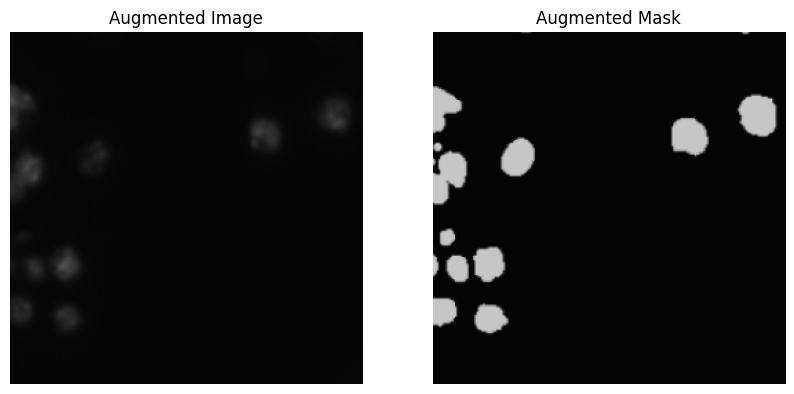

In [32]:
# Example usage
augmented_sample_folder = '/content/data/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552_augmented_1'
plot_augmented_sample(augmented_sample_folder)

**3.2. Summarize Key Statistics**

Calculate and summarize key statistics about the dataset.

In [33]:
# Get a list of all sample folders
sample_folders = [os.path.join(base_path, folder) for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

# Explore the first sample
sample_folder = sample_folders[0]
image_path = os.path.join(sample_folder, 'images', os.listdir(os.path.join(sample_folder, 'images'))[0])
masks_path = os.path.join(sample_folder, 'merged_masks')

# Load the image and masks
image = load_image(image_path)
masks = load_masks(masks_path)

In [34]:
# Number of images
num_images = len(sample_folders)
print(f"Number of images: {num_images}")

Number of images: 1340


In [35]:
# Distribution of mask sizes
mask_sizes = []
for folder in sample_folders:
    masks = load_masks(os.path.join(folder, 'merged_masks'))
    mask_sizes.extend([np.sum(mask > 0) for mask in masks])

mask_sizes = np.array(mask_sizes)
print(f"Average mask size: {np.mean(mask_sizes):.2f} pixels")
print(f"Median mask size: {np.median(mask_sizes):.2f} pixels")

Average mask size: 46369.21 pixels
Median mask size: 20710.50 pixels


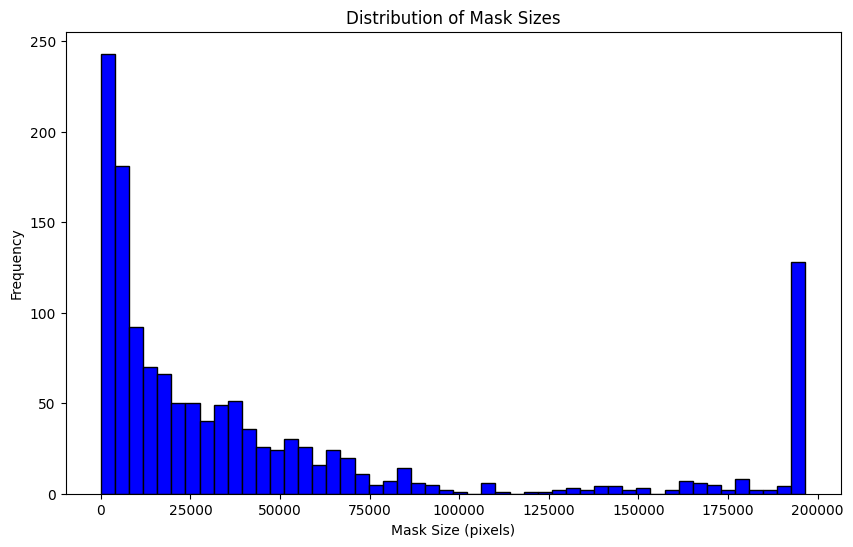

In [36]:
# Plot mask size distribution
plt.figure(figsize=(10, 6))
plt.hist(mask_sizes, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Mask Sizes')
plt.xlabel('Mask Size (pixels)')
plt.ylabel('Frequency')
plt.show()

## **Step 4: Cellpose Model**

In [31]:
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.0/205.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

In [32]:
!pip install "opencv-python-headless<4.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.


In [33]:
import os
import numpy as np
import cv2
from PIL import Image
from cellpose import models, train, io
import matplotlib.pyplot as plt

In [43]:
# Paths to the dataset
images_path = "/content/data/train/images"
masks_path = "/content/data/train/masks"

In [47]:
# Constants
OUTPUT_CHANNELS = 2
classes = {'nothing': 0, 'nucleon': 1}
chan = 0  # Channel index for grayscale images
chan2 = 0  # Channel index for grayscale images
initial_model = 'cyto'  # Initial model type
n_epochs = 50  # Number of epochs
learning_rate = 0.2  # Learning rate
weight_decay = 1e-5  # Weight decay
model_name = 'cellpose_model'  # Model name

In [48]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

In [49]:
def preprocessing(img):
    image = np.array(img)
    image = standardize(image)
    return image

In [51]:
def load_images_and_masks(images_folder, masks_folder):
    images = []
    masks = []
    for filename in os.listdir(images_folder):
        if filename.endswith('.png'):
            image_path = os.path.join(images_folder, filename)
            mask_filename = filename.replace('.png', '_merged_mask.png')
            mask_path = os.path.join(masks_folder, mask_filename)
            if not os.path.exists(mask_path):
                continue  # Skip if the corresponding mask does not exist
            image = Image.open(image_path).convert('L')  # Ensure image is in grayscale
            mask = Image.open(mask_path).convert('L')  # Ensure mask is in grayscale
            images.append(preprocessing(image))
            masks.append(np.array(mask))
    return images, masks

# Load training data
train_images, train_masks = load_images_and_masks(images_path, masks_path)

In [52]:
# Split data into training and validation sets
split_idx = int(0.8 * len(train_images))
X_train, X_val = train_images[:split_idx], train_images[split_idx:]
y_train, y_val = train_masks[:split_idx], train_masks[split_idx:]

In [55]:
train_dir = "/content/data/train/images"

# Ensure the model directory exists
model_path = os.path.join(train_dir, 'models')
os.makedirs(model_path, exist_ok=True)  # Create the models directory if it doesn't exist

# Check if a model with the same name already exists
model_full_path = os.path.join(model_path, model_name)
if os.path.exists(model_full_path):
    print("!! WARNING: " + model_name + " already exists and will be deleted !!")
    shutil.rmtree(model_full_path)

In [56]:
# Initialize logger
logger = io.logger_setup()

# Initialize Cellpose model
model = models.CellposeModel(gpu=True, model_type=initial_model)

# Set channels
channels = [chan, chan2]

# Train the model
new_model_path = train.train_seg(model.net, train_data=X_train,
                                 train_labels=y_train,
                                 test_data=X_val,
                                 test_labels=y_val,
                                 channels=channels,
                                 save_path=model_path,
                                 n_epochs=n_epochs,
                                 learning_rate=learning_rate,
                                 weight_decay=weight_decay,
                                 SGD=True,
                                 nimg_per_epoch=8,
                                 model_name=model_name,
                                 min_train_masks=1)

# Diameter of labels in training images
diam_labels = model.net.diam_labels.item()

print(f'Training completed. Model saved to {new_model_path}')
print(f'Diameter of labels in training images: {diam_labels}')

100%|██████████| 134/134 [00:00<00:00, 2420.48it/s]


Training completed. Model saved to /content/data/train/images/models/models/cellpose_model
Diameter of labels in training images: 38.20288848876953


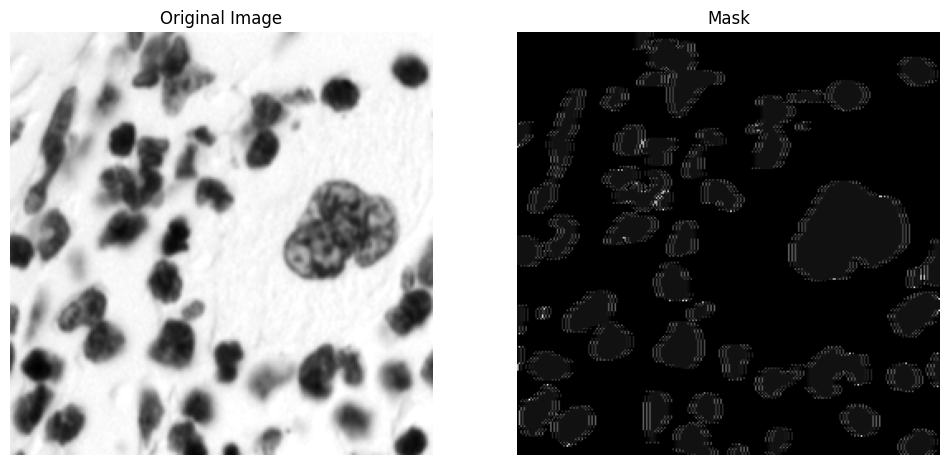

In [57]:
def display_image_and_mask(image, mask):
    """
    Display a single image and its mask.
    Args:
    - image (np.array): Image to be displayed.
    - mask (np.array): Mask to be displayed.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')  # Display image
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')  # Display mask
    ax[1].set_title('Mask')
    ax[1].axis('off')

    plt.show()

# Display an example from the validation set
display_image_and_mask(X_val[0], y_val[0])

In [60]:
def load_images(images_folder):
    images = []
    filenames = []
    for filename in os.listdir(images_folder):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(images_folder, filename)
            image = Image.open(image_path).convert('L')  # Ensure image is in grayscale
            images.append(preprocessing(image))
            filenames.append(filename)
    return images, filenames

In [62]:
def display_image_and_mask(image, mask, title_image="Original Image", title_mask="Mask"):
    """
    Display a single image and its mask.
    Args:
    - image (np.array): Image to be displayed.
    - mask (np.array): Mask to be displayed.
    - title_image (str): Title for the image subplot.
    - title_mask (str): Title for the mask subplot.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image, cmap='gray')  # Display image
    ax[0].set_title(title_image)
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')  # Display mask
    ax[1].set_title(title_mask)
    ax[1].axis('off')

    plt.show()

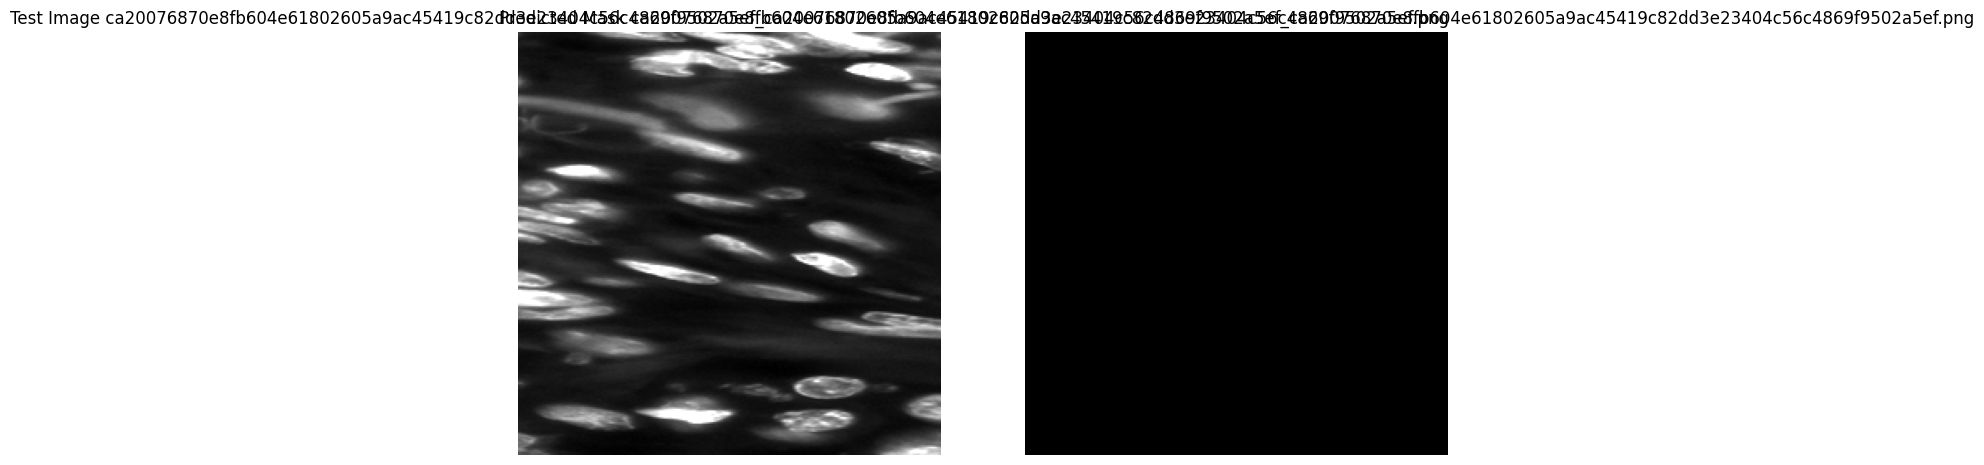

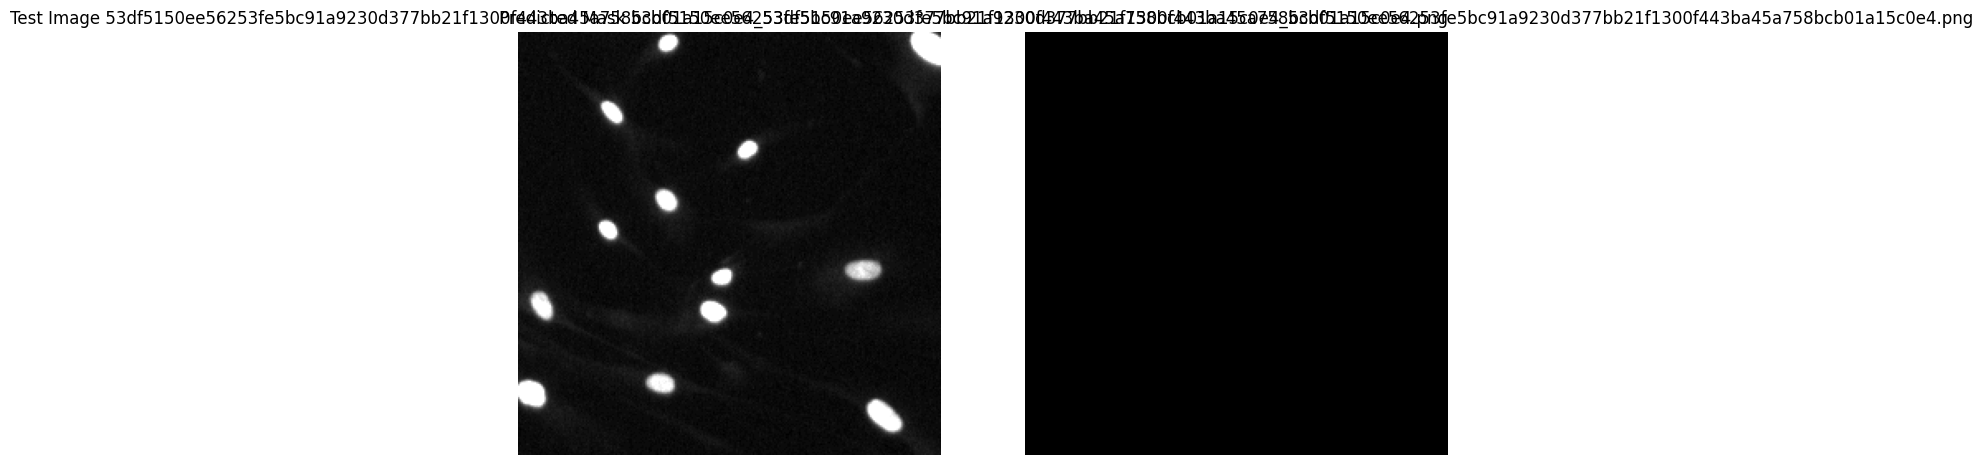

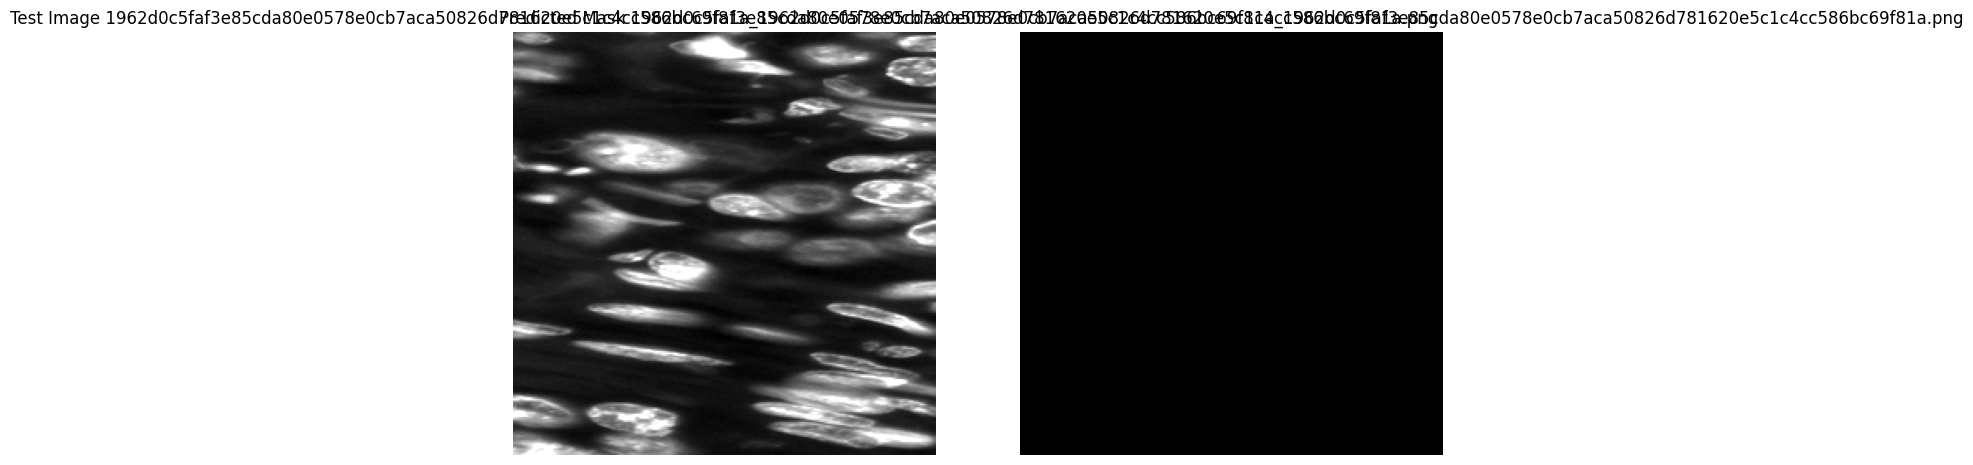

In [63]:
test_images_path = "/content/data/test/images"

# Load test data
test_images, test_filenames = load_images(test_images_path)

# Make predictions
test_predictions = model.eval(test_images, diameter=None, channels=channels)[0]

# Display some predictions
for i in range(min(3, len(test_images))):  # Display up to 3 examples
    display_image_and_mask(test_images[i], test_predictions[i],
                           title_image=f"Test Image {test_filenames[i]}",
                           title_mask=f"Predicted Mask {test_filenames[i]}")

In [69]:
from sklearn.metrics import jaccard_score, f1_score

def calculate_metrics(y_true_list, y_pred_list):
    """
    Calculate evaluation metrics for the segmentation.

    Args:
    - y_true_list (list of np.array): List of ground truth masks.
    - y_pred_list (list of np.array): List of predicted masks.

    Returns:
    - dict: Dictionary containing IoU and Dice scores.
    """
    # Concatenate all arrays in the lists
    y_true = np.concatenate([y.flatten() for y in y_true_list])
    y_pred = np.concatenate([y.flatten() for y in y_pred_list])

    # Calculate IoU
    iou = jaccard_score(y_true, y_pred, average='macro')

    # Calculate Dice coefficient (F1 score)
    dice = f1_score(y_true, y_pred, average='macro')

    return {'IoU': iou, 'Dice': dice}

In [67]:
# Make predictions on the validation set
val_predictions = model.eval(X_val, diameter=None, channels=channels)[0]

In [70]:
# Calculate metrics
metrics = calculate_metrics(y_val, val_predictions)
print(f"Validation Metrics: IoU = {metrics['IoU']:.4f}, Dice = {metrics['Dice']:.4f}")

Validation Metrics: IoU = 0.0033, Dice = 0.0036
